In [1]:
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc, multilabel_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Data observation and preprocessing

In [2]:
columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"]
df = pd.read_csv("../../data/processed.cleveland.data", names = columns)
print(len(df))
df[:5]

303


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [3]:
# remove data with ?
df = df[df.apply(lambda x: "?" not in x.values, axis=1)]
print(len(df))

297


In [4]:
features = columns[:-1]
target = columns[-1]
n_classes = len(df[target].unique()) # 4 classes to preict. 0 is absence 

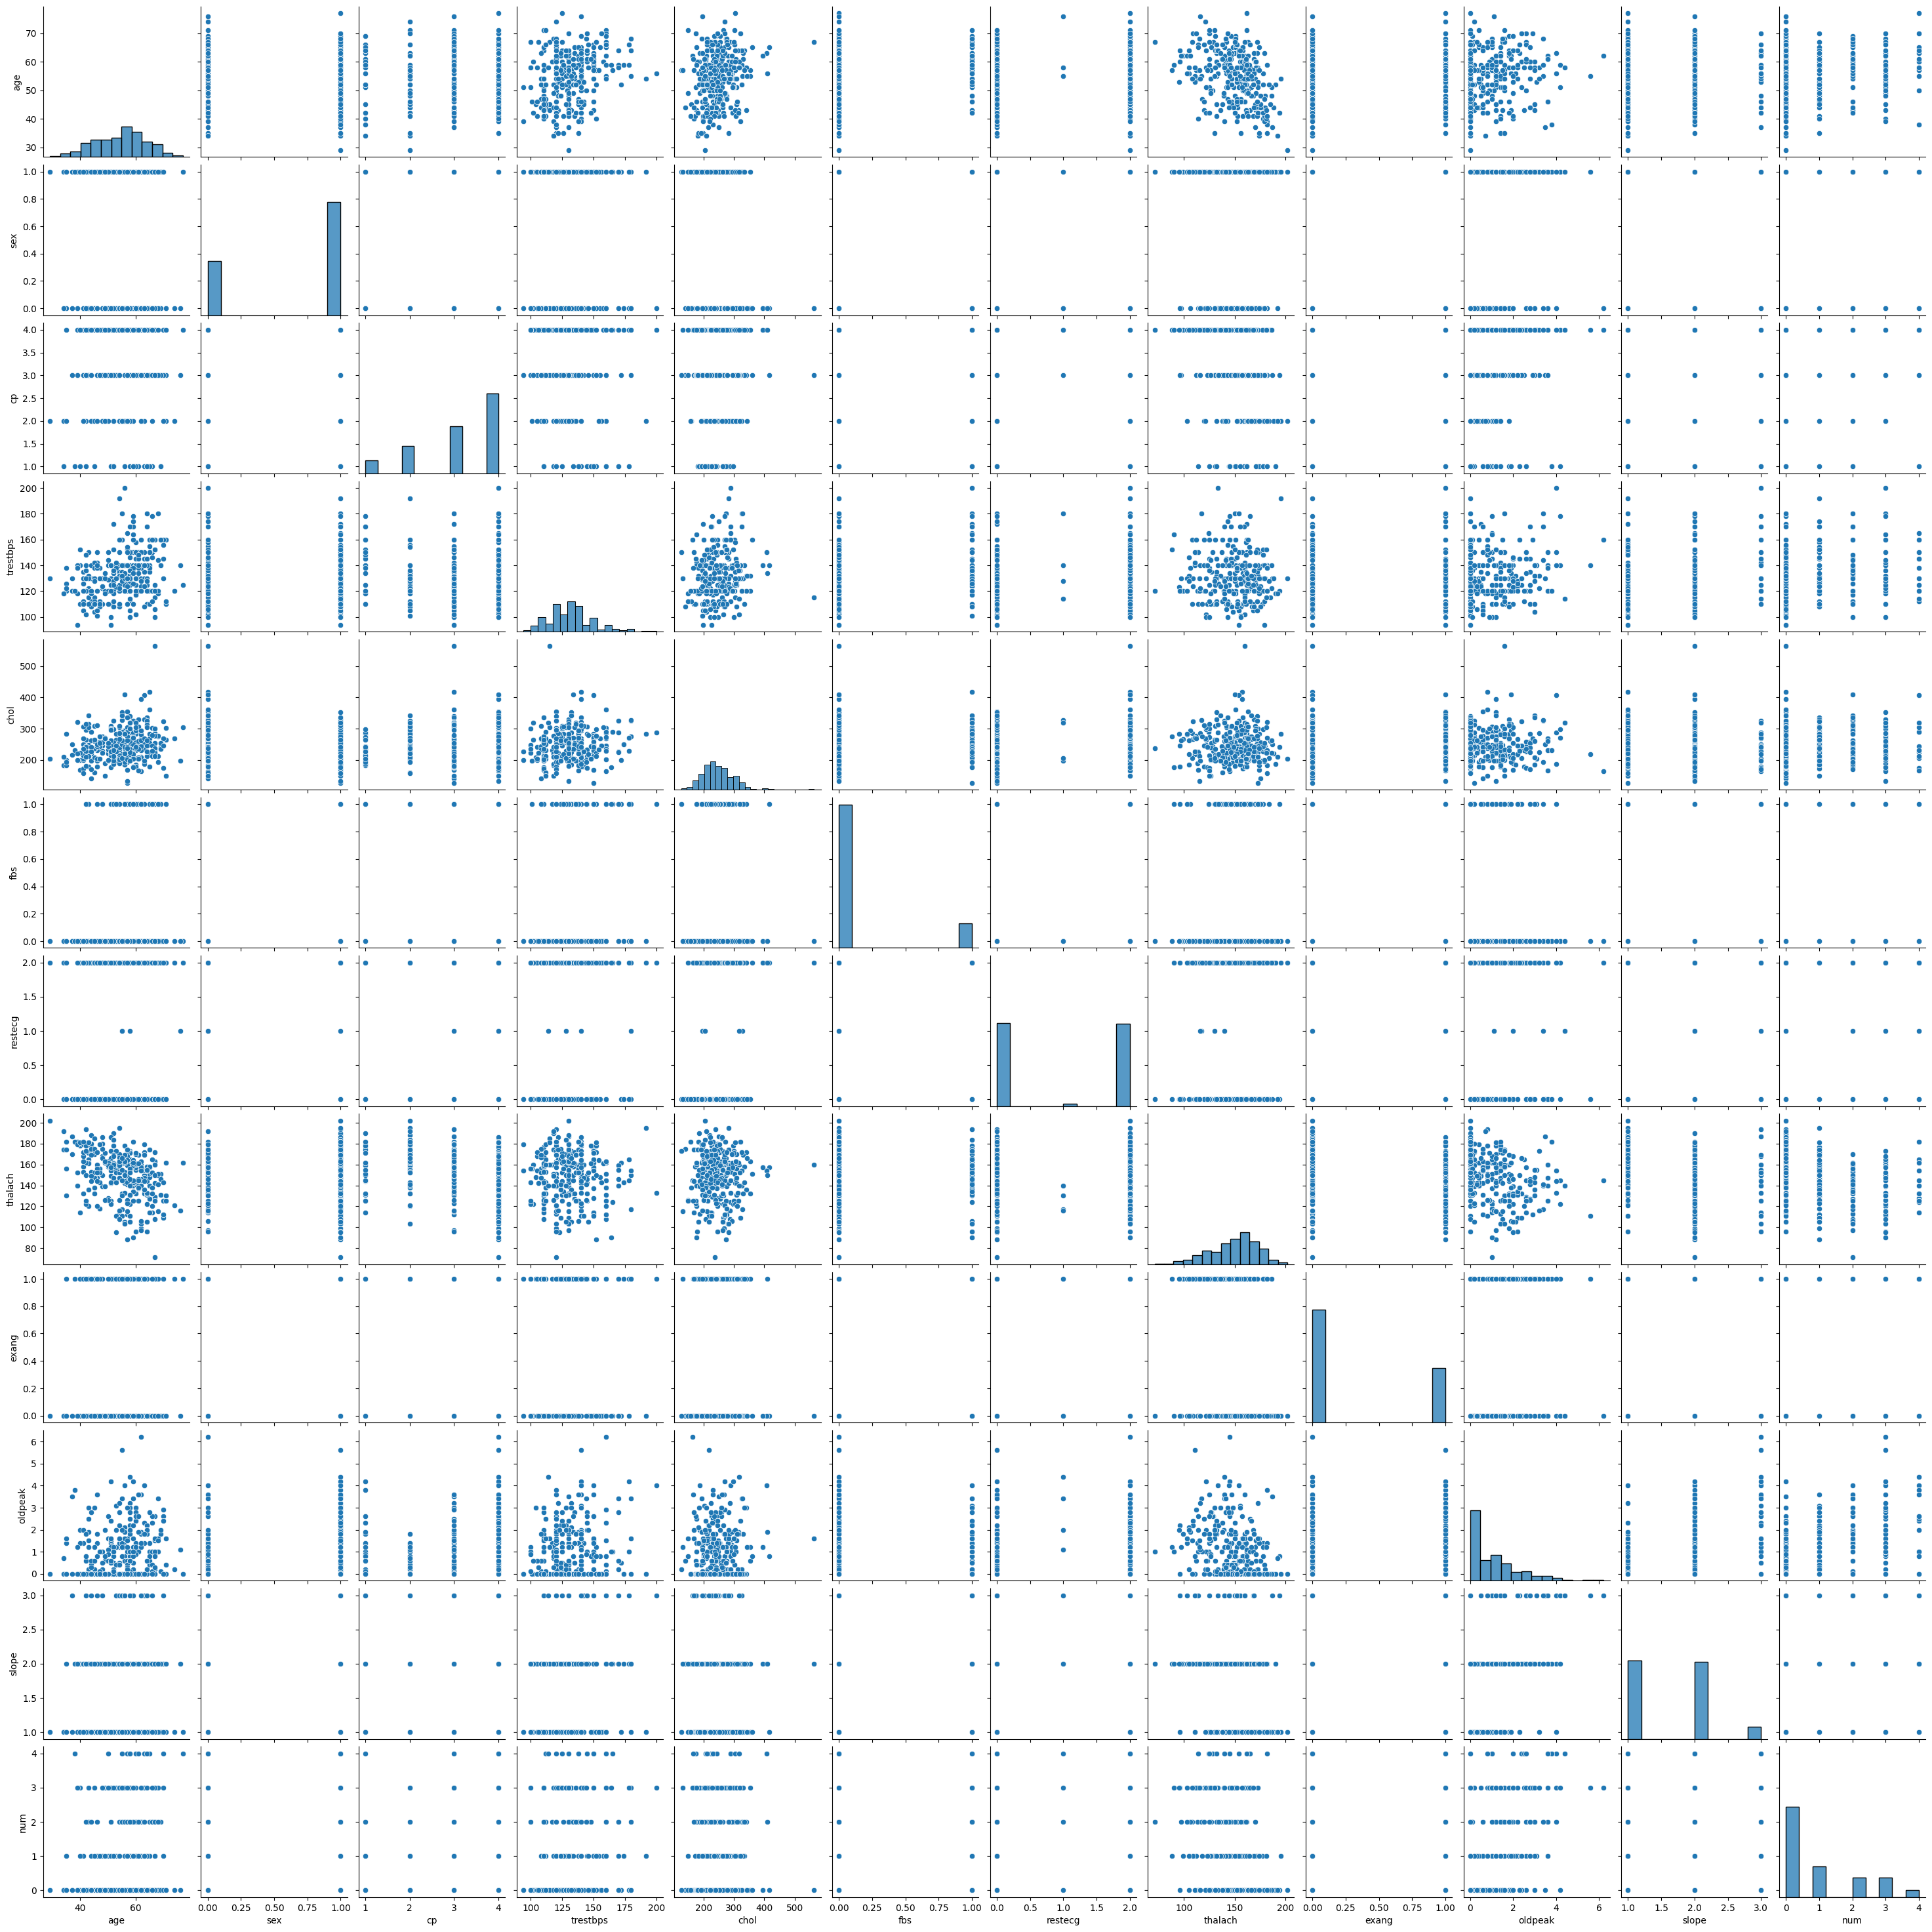

In [5]:
sns.pairplot(df)

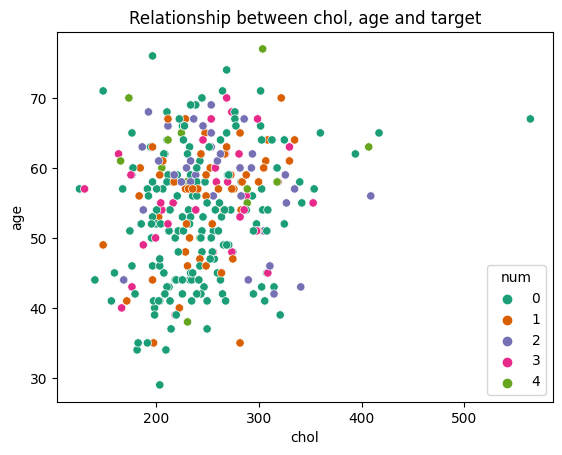

In [6]:
plt.title("Chol to age")
sns.scatterplot(x="chol", y="age", hue=target, data=df, palette="Dark2")
plt.title("Relationship between chol, age and target")
plt.show()
# not very informative

# Models multilabel

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.3, random_state=726754)
print("Train len:", len(X_train),", test len:" ,len(X_test))
Counter(y_train), Counter(y_test)

Train len: 207 , test len: 90


(Counter({1: 41, 3: 19, 2: 28, 0: 109, 4: 10}),
 Counter({0: 51, 4: 3, 3: 16, 1: 13, 2: 7}))

In [8]:
def metrics(y_truth, y_pred):
    conf_m = multilabel_confusion_matrix(y_truth, y_pred) # np.argmax(probs, axis= 1)
    m = {}
    for i in range(len(conf_m)):
        tn, fp, fn, tp = conf_m[i].ravel()
        acc = (tn + tp)/ (tn + tp + fn + fp)
        m[i] = [("acc", acc), ("specificity", tn / (tn + fp)), ("sensitivity",  tp / (tp + fn))]
    return m

def print_m(m):
    avgs = defaultdict(list)
    for c, matrix in m.items():
        for name, value in matrix:
            print(f"For class {c}: {name:>12}={value:.3f}")
            avgs[name].append(value)
        print("\n")
    for name, values in avgs.items():
        print(f"Avg {name}: {np.mean(values)}")
        
def roc_auc_plots(y_test, probs):
    classes = np.unique(y_test)
    # print(classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in classes:
        y = (y_test == i).astype(int)
        fpr[i], tpr[i], _ = roc_curve(y, probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fig, axes = plt.subplots(1, len(classes), figsize = (len(classes)*5, 3))
    for i in range(len(classes)):
        axes[i].title.set_text(f"Class: {classes[i]}")
        lw = 2
        axes[i].plot(
            fpr[classes[i]],
            tpr[classes[i]],
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc[classes[i]],
        )
        axes[i].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        axes[i].set_xlim([0.0, 1.0])
        axes[i].set_ylim([0.0, 1.05])
        axes[i].set_xlabel("False Positive Rate")
        axes[i].set_ylabel("True Positive Rate")
        
        axes[i].legend(loc="lower right")
    plt.show()

## Trees

### Decision trees

For class 0:          acc=0.767
For class 0:  specificity=0.795
For class 0:  sensitivity=0.745


For class 1:          acc=0.678
For class 1:  specificity=0.766
For class 1:  sensitivity=0.154


For class 2:          acc=0.789
For class 2:  specificity=0.831
For class 2:  sensitivity=0.286


For class 3:          acc=0.822
For class 3:  specificity=0.973
For class 3:  sensitivity=0.125


For class 4:          acc=0.922
For class 4:  specificity=0.954
For class 4:  sensitivity=0.000


Avg acc: 0.7955555555555556
Avg specificity: 0.86388536475782
Avg sensitivity: 0.2619316957552252


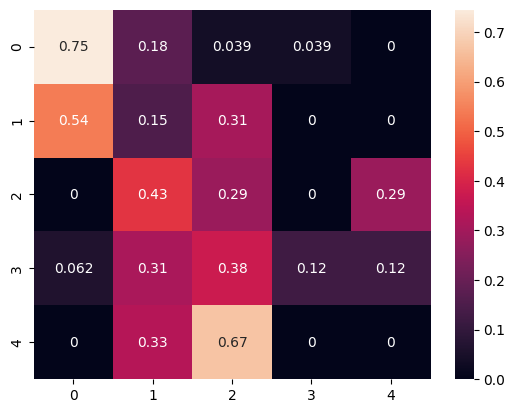

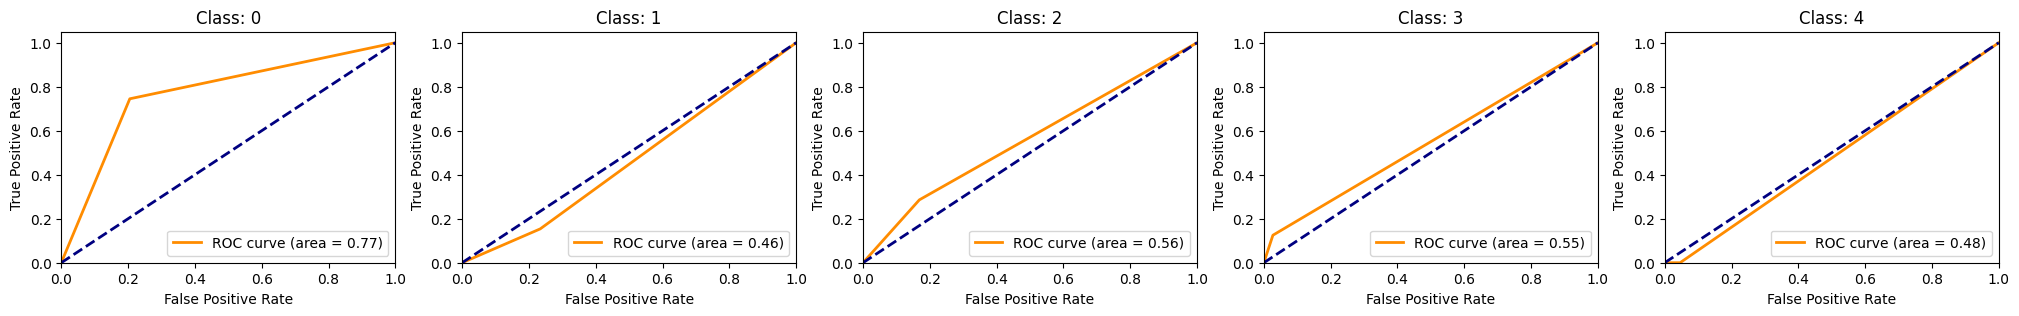

In [9]:
clf = DecisionTreeClassifier(random_state=123456)
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)
pred = np.argmax(probs, axis= 1)
m = metrics(y_test, pred)
print_m(m)
cm = confusion_matrix(y_test, pred, normalize = "true")
sns.heatmap(cm, annot = True)
plt.show()

roc_auc_plots(y_test, probs)

In [10]:
for name, importance in zip(features, clf.feature_importances_):
    print(f"importance of {name:>10} is {importance}")

importance of        age is 0.0717610272902335
importance of        sex is 0.026574424078168464
importance of         cp is 0.029777782306132653
importance of   trestbps is 0.11850978489713995
importance of       chol is 0.16793905955905442
importance of        fbs is 0.030904042144846447
importance of    restecg is 0.007381784466157908
importance of    thalach is 0.1357545336243642
importance of      exang is 0.03406874114177824
importance of    oldpeak is 0.09413703537893198
importance of      slope is 0.0405998145638685
importance of         ca is 0.08675145288778567
importance of       thal is 0.15584051766153822


### Random forest

For class 0:          acc=0.822
For class 0:  specificity=0.744
For class 0:  sensitivity=0.882


For class 1:          acc=0.744
For class 1:  specificity=0.831
For class 1:  sensitivity=0.231


For class 2:          acc=0.789
For class 2:  specificity=0.831
For class 2:  sensitivity=0.286


For class 3:          acc=0.789
For class 3:  specificity=0.959
For class 3:  sensitivity=0.000


For class 4:          acc=0.967
For class 4:  specificity=1.000
For class 4:  sensitivity=0.000


Avg acc: 0.8222222222222222
Avg specificity: 0.8731086670845707
Avg sensitivity: 0.2797672915319974


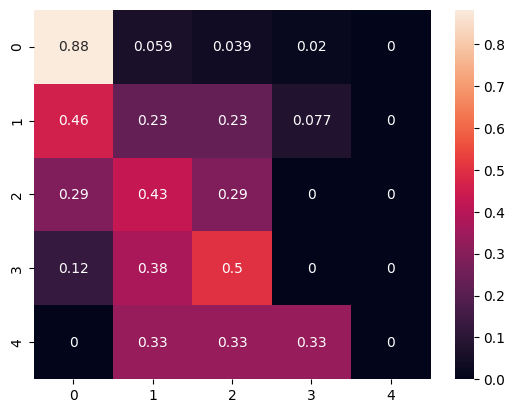

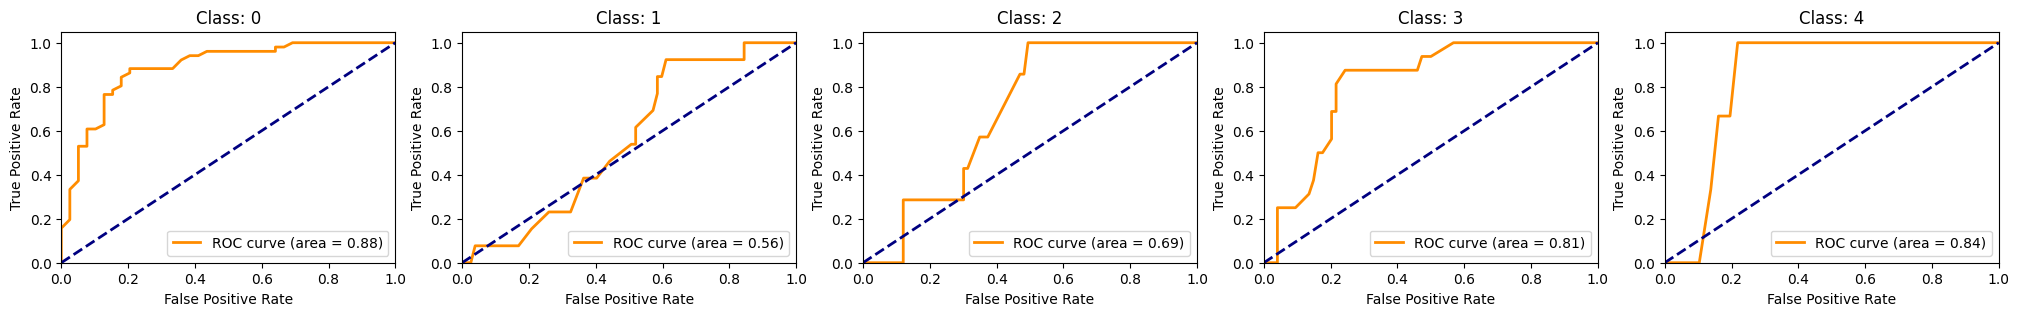

In [11]:
clf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)
pred = np.argmax(probs, axis= 1)
m = metrics(y_test, pred)
print_m(m)
cm = confusion_matrix(y_test, pred, normalize = "true")
sns.heatmap(cm, annot = True)
plt.show()
roc_auc_plots(y_test, probs)

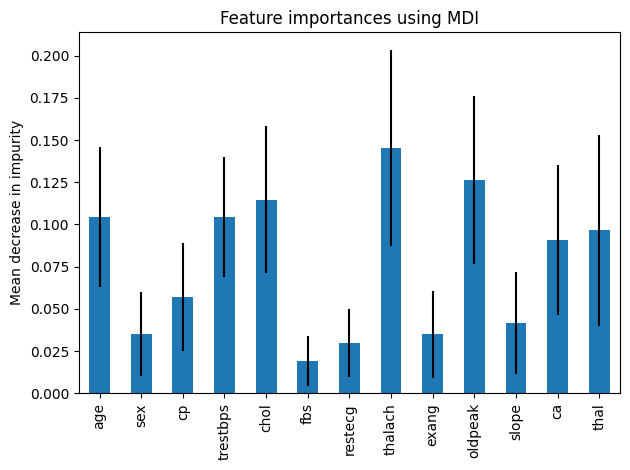

In [12]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Models binary

In [13]:
y_test = (y_test > 0).astype(int)
y_train = (y_train > 0).astype(int)

### Decision Tree

For class 0:          acc=0.722
For class 0:  specificity=0.821
For class 0:  sensitivity=0.647


For class 1:          acc=0.722
For class 1:  specificity=0.647
For class 1:  sensitivity=0.821


Avg acc: 0.7222222222222222
Avg specificity: 0.7337858220211162
Avg sensitivity: 0.7337858220211162


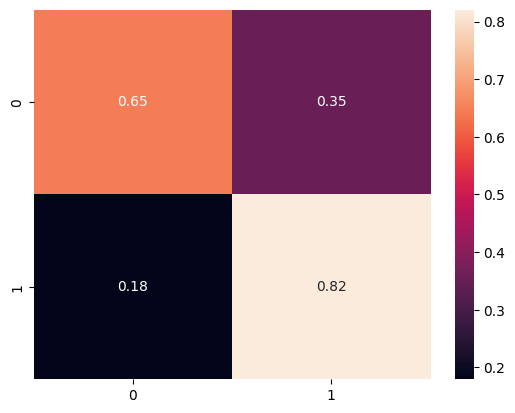

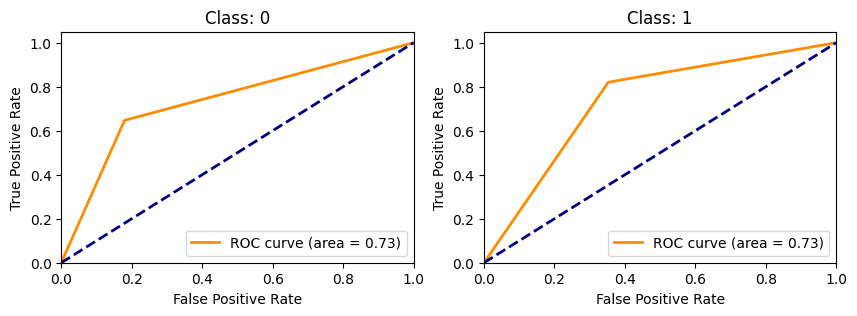

In [14]:
clf = DecisionTreeClassifier(random_state=123456)
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)
pred = np.argmax(probs, axis= 1)
print_m(metrics(y_test, pred))
cm = confusion_matrix(y_test, pred, normalize = "true")
sns.heatmap(cm, annot = True)
plt.show()
roc_auc_plots(y_test, probs)

In [15]:
for name, importance in zip(features, clf.feature_importances_):
    print(f"importance of {name:>10} is {importance}")

importance of        age is 0.06232232173903076
importance of        sex is 0.0
importance of         cp is 0.06399945168106563
importance of   trestbps is 0.10632281894123254
importance of       chol is 0.08961980874297709
importance of        fbs is 0.0
importance of    restecg is 0.03890977443609024
importance of    thalach is 0.04002925306150603
importance of      exang is 0.05389397947217789
importance of    oldpeak is 0.1132729431705081
importance of      slope is 0.009689196779629282
importance of         ca is 0.10437904009619121
importance of       thal is 0.31756141187959114


### Random Forest

For class 0:          acc=0.833
For class 0:  specificity=0.872
For class 0:  sensitivity=0.804


For class 1:          acc=0.833
For class 1:  specificity=0.804
For class 1:  sensitivity=0.872


Avg acc: 0.8333333333333334
Avg specificity: 0.8378582202111614
Avg sensitivity: 0.8378582202111614


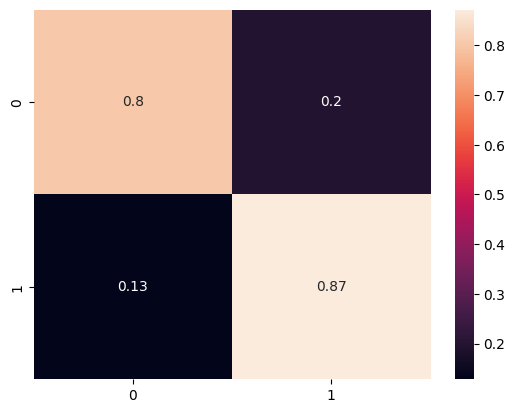

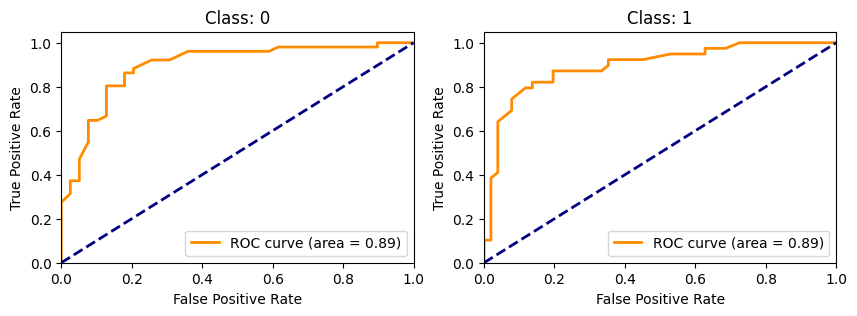

In [16]:
clf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)
pred = np.argmax(probs, axis= 1)
print_m(metrics(y_test, pred))
cm = confusion_matrix(y_test, pred, normalize = "true")
sns.heatmap(cm, annot = True)
plt.show()
roc_auc_plots(y_test, probs)

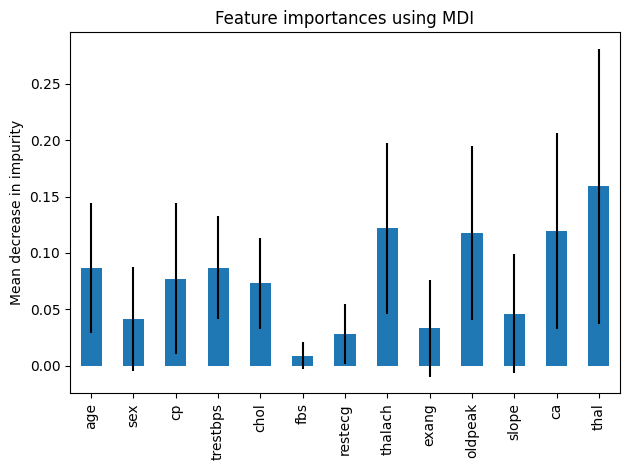

In [17]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()